In [ ]:
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
features=pd.read_csv('features.csv')
stores=pd.read_csv('stores.csv')

In [ ]:
train=train.merge(features,on=['Store','Date','IsHoliday'],how='left')
test=test.merge(features,on=['Store','Date','IsHoliday'],how='left')

In [ ]:
train=train.merge(stores,on=['Store'],how='left')
test=test.merge(stores,on=['Store'],how='left')

In [ ]:
train['Date']=pd.to_datetime(train['Date'])
test['Date']=pd.to_datetime(test['Date'])

In [ ]:
train['Year']=train['Date'].dt.year
train['Month']=train['Date'].dt.month
train['Week']=train['Date'].dt.isocalendar().week
train['Day']=train['Date'].dt.day

In [ ]:
test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Week']=test['Date'].dt.isocalendar().week
test['Day']=test['Date'].dt.day

In [ ]:
train_Type=train.dtypes
train_Type

,0
Store,int64
Dept,int64
Date,datetime64[ns]
Weekly_Sales,float64
IsHoliday,bool
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train['Type']=le.fit_transform(train['Type'])
train['IsHoliday']=le.fit_transform(train['IsHoliday'])
test['Type']=le.fit_transform(test['Type'])
test['IsHoliday']=le.fit_transform(test['IsHoliday'])

In [ ]:
train = train.sort_values(['Store', 'Dept', 'Date'])

train['Sales_Lag_1'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)

train['Rolling_Mean_4'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(4).mean())

test = test.sort_values(['Store', 'Dept', 'Date'])

test['Sales_Lag_1'] = test.groupby(['Store', 'Dept'])['Temperature'].shift(1) #Using Temperature as placeholder as Weekly_Sales is not in test set

test['Rolling_Mean_4'] = test.groupby(['Store', 'Dept'])['Temperature'].transform(lambda x: x.rolling(4).mean()) #Using Temperature as placeholder as Weekly_Sales is not in test set

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
features = ['Store', 'Dept', 'Day', 'Month', 'Year', 'Week', 'IsHoliday',
            'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size',
            'Sales_Lag_1', 'Rolling_Mean_4']

In [ ]:
X=train[features]
y=train['Weekly_Sales']

In [ ]:
train=train.sort_values('Date')

In [ ]:
cutof_Date='2012-01-01'

In [ ]:
X_train = train[train['Date'] < cutof_Date][features]
y_train = train[train['Date'] < cutof_Date]['Weekly_Sales']

X_val = train[train['Date'] >= cutof_Date][features]
y_val = train[train['Date'] >= cutof_Date]['Weekly_Sales']

In [ ]:
model=xg.XGBRegressor(n_estimators=1000,learning_rate=0.05)
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

print(f'MSE: {mean_squared_error(y_val,model.predict(X_val))}')
print(f'R2: {r2_score(y_val,model.predict(X_val))}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_val,model.predict(X_val)))}')

MSE: 7757713.291727653
R2: 0.9841457552758873
RMSE: 2785.2671849802223


In [ ]:
important=pd.DataFrame({'Feature':features,'Importance':model.feature_importances_})
print(important.sort_values('Importance',ascending=False))

          Feature  Importance
0  Rolling_Mean_4    0.553159
1     Sales_Lag_1    0.346374
2       IsHoliday    0.037995
3            Week    0.016686
6            Dept    0.012511
5           Month    0.010640
4             Day    0.009027
8            Size    0.005310
7            Year    0.004486
9    Unemployment    0.003812


In [ ]:
features=['Rolling_Mean_4','Sales_Lag_1','IsHoliday','Week','Day','Month','Dept','Year','Size','Unemployment']

In [ ]:
y_pred=model.predict(test[features])

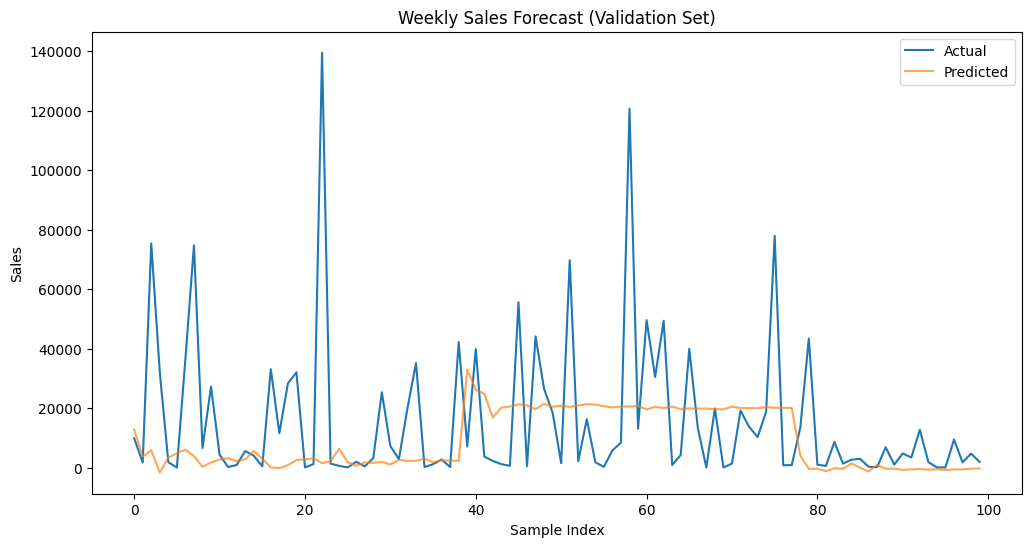

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_val.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
plt.legend()
plt.title('Weekly Sales Forecast (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.show()

In [ ]:
test['Weekly_Sales_Predict']=model.predict(test[features])

In [ ]:
test[['Store','Dept','Date','Weekly_Sales_Predict']].to_csv('Test_Result.csv',index=False)

In [ ]:
train['Weekly_Sales'].describe()

,Weekly_Sales
count,421570.000000
mean,15981.258123
std,22711.183519
min,-4988.940000
25%,2079.650000
50%,7612.030000
75%,20205.852500
max,693099.360000
